In [22]:
from BaroSphere import BaroSphere
import matplotlib.pyplot as plt
import numpy as np
#from mpl_toolkits.basemap import Basemap\
import cartopy.crs as ccrs
import cartopy
plt.style.use('dark_background')
B=BaroSphere(
    ntrunc=42,
    dt=1800,
    damping_order=2,
    efold=3*3600,
    nlat=64,
    do_tracers=1,
    ntracers=3,
    tracer_fix=False
)

print(B.lons1.shape,B.lats1.shape)
print(B.ntracers)

# note - dt=1800 works well for up to T85
# 100 days at T85 takes 40 seconds

(128,) (64,)
3


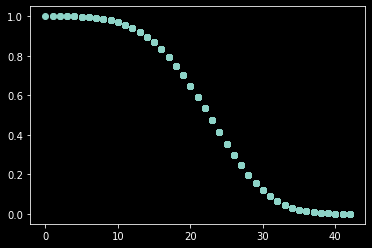

In [23]:
plt.plot(B.indxn,np.power(B.hyperdiff_fact,1*24*3600/B.dt),'o')
#plt.xlim([0,)
#plt.ylim([0.9,1])

In [24]:
#total number of steps to take
Nsteps = int(60*24*3600/B.dt)
#how often to take snapshots
dN_snap = int(6*3600/B.dt)
#total number of snapshots
Nsnaps = int(Nsteps/dN_snap)

print(Nsteps,dN_snap,Nsnaps)

#first time step 
# vrt0 = #0*B.vrtg_unstable_jet(m=12,A=8e-5) #initialiae with 0 
# __,tend_vrt = B.model_time_tendency(vrt0)
# vrt1 = vrt0 + B.dt * tend_vrt

B.vrtg_m1 = np.zeros([B.nlat,B.nlon])
B.vrtg = np.zeros([B.nlat,B.nlon])

tracers0 = np.exp(-(B.lats-45)**2/100)
tracers1 = np.exp(-(B.lats-60)**2/100)
tracers2 = np.exp(-(B.lats-30)**2/100)

B.tracers_m1 = tracers0
B.tracers = tracers0

print(B.tracers.shape,B.tracers_m1.shape)

#initialize the snapshots
vrt = np.zeros([Nsnaps+1,B.nlat,B.nlon])
tracers = np.zeros([Nsnaps+1,B.ntracers,B.nlat,B.nlon])
#vrt[0] = vrt0
ksnap = 1

#stocahstic realization decay time scale
tau=2*3600*24
#noise strength
NS=1.e-10

#damping timescale for the mean drag
tdamp=10*24*3600

#spectral filter for the noise realization
B.w_indxm_damp = np.ones(len(B.indxm))
B.w_indxm_damp[B.indxm>14] = 0
B.w_indxm_damp[B.indxm<10] = 0

#noise realization container
W = np.zeros(len(B.w_indxm_damp))
#sine of latitude
s=np.sin(B.lats*B.a)
#grid space filter
damping_window=np.exp( - np.power( (s - 0.7) / 0.2 ,2) ) 

#reset tracers after an initial spinup time 
Nspinup = 100

#main time loop
for i in range(1,Nsteps+1):
    #timestep the model
    B.RA_leapfrog()
    #time step the noise realization
    W = (1-B.dt/tau) * W + NS*np.sqrt(B.dt / (2 * tau) )*np.random.randn(len(W))
    #add the noise to the model spectrally
    B.vrtg += B.x.spectogrd(B.w_indxm_damp * W * B.dt) * damping_window    
    #apply mean "drag" to the model
    B.vrtg = B.vrtg * tdamp / (tdamp + B.dt)


    #store data sometimes
    if i%dN_snap == 0:
        vrt[ksnap] = np.copy(B.vrtg)
        print(i,i*B.dt/3600/24,ksnap,np.max(vrt[ksnap]))
        if B.do_tracers:
            tracers[ksnap]=np.copy(B.tracers)
        ksnap += 1
        if ksnap==Nspinup:
            B.tracers_m1[0] = tracers0
            B.tracers[0] = tracers0
            B.tracers_m1[1] = tracers1
            B.tracers[1] = tracers1
            B.tracers_m1[2] = tracers2
            B.tracers[2] = tracers2


2880 12 240
(64, 128) (64, 128)
12 0.25 1 4.2543032428292315e-06
24 0.5 2 8.421219663167848e-06
36 0.75 3 1.2177293766832092e-05
48 1.0 4 1.8223861412468545e-05
60 1.25 5 2.5163309768678742e-05
72 1.5 6 2.6965124886908923e-05
84 1.75 7 3.280285106906029e-05
96 2.0 8 3.8847376606010845e-05
108 2.25 9 4.2195080705916435e-05
120 2.5 10 5.125208867214264e-05
132 2.75 11 5.956557303426977e-05
144 3.0 12 6.834471263301223e-05
156 3.25 13 7.484606060580875e-05
168 3.5 14 8.036839444647212e-05
180 3.75 15 8.430464334569082e-05
192 4.0 16 9.064766890107966e-05
204 4.25 17 9.415354657135982e-05
216 4.5 18 9.427067829516722e-05
228 4.75 19 9.816596884737392e-05
240 5.0 20 0.00010539101835595843
252 5.25 21 0.00010768196297704926
264 5.5 22 0.00010722658544654906
276 5.75 23 0.00010672749771413214
288 6.0 24 0.00010566009748765807
300 6.25 25 0.00010023898689033708
312 6.5 26 9.34961872473514e-05
324 6.75 27 8.974573574960232e-05
336 7.0 28 8.567325188052257e-05
348 7.25 29 8.175515505851183e-05
3

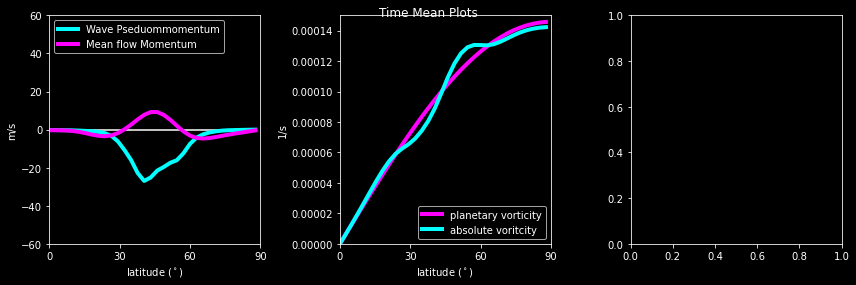

In [ ]:
u,v=B.get_uv_vrtg(vrt[120:].mean(axis=0))

beta=B.omega*2*np.cos(np.pi/4)/B.rsphere

A=-np.power(vrt-vrt.mean(axis=-1)[:,:,np.newaxis],2)/(2*beta)
A=A[20:].mean(axis=0)

lw=4

plt.figure(0,figsize=(12,4))

plt.subplot(1,3,1)

plt.ylabel('m/s')
plt.xlabel('latitude ($^\\circ$)')
plt.xlim([0,90])
plt.plot(B.lats1,0*B.lats1,'w')
plt.xticks(np.linspace(0,90,4))
plt.plot(B.lats1,A.mean(axis=-1),label='Wave Pseduommomentum',
linewidth=lw,color='cyan',alpha=1,linestyle='-')
plt.plot(B.lats1,u.mean(axis=-1),label='Mean flow Momentum',
linewidth=lw,color='magenta',alpha=1,linestyle='-')
plt.legend(loc=2)
plt.ylim([-60,60])

# plt.axvline(180/np.pi*np.arcsin(0.55),linestyle='--',color='green')
#plt.axvline(180/np.pi*np.arcsin(0.85),linestyle='--',color='green')

# plt.annotate('Stirring \nRegion',(15,-30),color='white')

#plt.gca().twinx()
#plt.plot(B.lats1,damping_window[:,0],'w--',label='Stirring Region')
#plt.ylabel('')

plt.legend(loc=2)

plt.subplot(1,3,2)

plt.ylabel('1/s')
plt.xlabel('latitude ($^\\circ$)')
plt.xticks(np.linspace(-90,90,7))
plt.plot(B.lats1,B.f.mean(axis=-1),
label='planetary vorticity',linewidth=lw,color='magenta')
plt.plot(B.lats1,B.f.mean(axis=-1)+vrt[20*4:].mean(axis=(0,-1)),
label='absolute voritcity',linewidth=lw,color='cyan')
# plt.axvline(180/np.pi*np.arcsin(0.55),linestyle='--',color='green')
# plt.axvline(180/np.pi*np.arcsin(0.85),linestyle='--',color='green')
plt.xlim([0,90])
plt.ylim([-1.5e-4*0,1.5e-4])
plt.legend()

plt.subplot(1,3,3)




plt.suptitle('Time Mean Plots')

plt.tight_layout()

plt.savefig('TimeMean.png')

<ipython-input-21-34f3aa4d3b5f>:13: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax=plt.subplot(4,4,i+1,projection=cproj)


<Figure size 432x288 with 0 Axes>

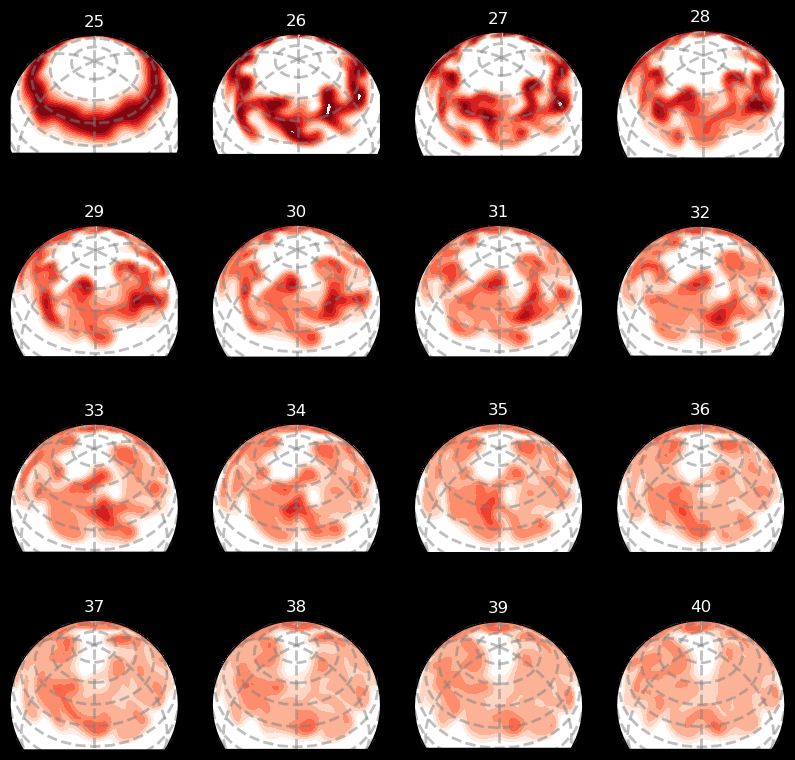

In [ ]:

# look at some sample data to make sure things are working 
plt.clf()
plt.figure(0,figsize=(10,10),dpi=100)
lim=5e-5
crs = ccrs.RotatedPole(pole_longitude=0, pole_latitude=45)
cproj=ccrs.Orthographic(-0, 0)
for i in range(0,16):
    ind=100+i*4
    ax=plt.subplot(4,4,i+1,projection=cproj)
    ax.contourf(B.lons1,B.lats1,tracers[ind,0],
    cmap=plt.cm.Reds,alpha=1,
    levels=np.linspace(0.1,1,10),transform=crs)    
    ax=plt.subplot(4,4,i+1,projection=cproj)
    # ax.contourf(B.lons1,B.lats1,tracers[ind,1],
    # cmap=plt.cm.Blues,alpha=0.5,
    # levels=[0.25,1],transform=crs)    
    # ax=plt.subplot(4,4,i+1,projection=cproj)
    # ax.contourf(B.lons1,B.lats1,tracers[ind,2],
    # cmap=plt.cm.Greens,alpha=0.5,
    # levels=[0.25,1],transform=crs)    
    # ax.contour(B.lons1,B.lats1,tracers[ind,1],
    # vmin=0,vmax=1,
    # cmap=plt.cm.Blues,alpha=0.5,
    # transform=crs)    
    # ax.contour(B.lons1,B.lats1,tracers[ind,2],
    # vmin=0,vmax=1,
    # cmap=plt.cm.Greens,alpha=0.5,
    # transform=crs)    
    gl = ax.gridlines(crs=crs, draw_labels=False,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    plt.title(int((dN_snap*B.dt*ind)/(3600*24)))
#    plt.title(1+i*0.5)
#    plt.yticks([])
#    plt.xticks([])
#    plt.ylim([-90,90])
#plt.savefig('test0.png')

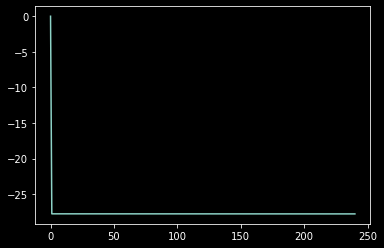

In [ ]:
plt.plot( (B.ds[np.newaxis,:,:]*tracers[:,0]).sum(axis=(-1,-2)))

In [ ]:
B.ds[1]

array([-0.00414584, -0.00414584, -0.00414584, -0.00414584, -0.00414584,
       -0.00414584, -0.00414584, -0.00414584, -0.00414584, -0.00414584,
       -0.00414584, -0.00414584, -0.00414584, -0.00414584, -0.00414584,
       -0.00414584, -0.00414584, -0.00414584, -0.00414584, -0.00414584,
       -0.00414584, -0.00414584, -0.00414584, -0.00414584, -0.00414584,
       -0.00414584, -0.00414584, -0.00414584, -0.00414584, -0.00414584,
       -0.00414584, -0.00414584, -0.00414584, -0.00414584, -0.00414584,
       -0.00414584, -0.00414584, -0.00414584, -0.00414584, -0.00414584,
       -0.00414584, -0.00414584, -0.00414584, -0.00414584, -0.00414584,
       -0.00414584, -0.00414584, -0.00414584, -0.00414584, -0.00414584,
       -0.00414584, -0.00414584, -0.00414584, -0.00414584, -0.00414584,
       -0.00414584, -0.00414584, -0.00414584, -0.00414584, -0.00414584,
       -0.00414584, -0.00414584, -0.00414584, -0.00414584, -0.00414584,
       -0.00414584, -0.00414584, -0.00414584, -0.00414584, -0.00

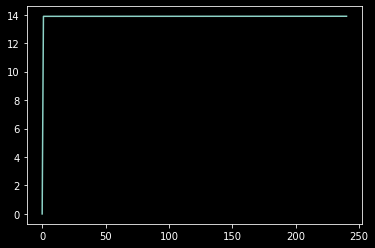

In [ ]:
plt.plot(np.sum(B.ds*tracers[:,0],axis=(1,2))/-2.)